In [24]:
# Import dependencies

import numpy as np
import pandas as pd

import os

%load_ext autoreload
%autoreload 2

SEED = 42
np.random.seed(SEED)

SLIDING_WINDOW_SIZE = 10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# Load data
import helpers

GROUPING_FEATURE = "datetime_key"
LABEL = "activity"
FEATURES = ["acceleration_x", "acceleration_y", "acceleration_z", "gyro_x", "gyro_y", "gyro_z"]

data_path = os.path.join('dataset', 'dataset_preprocessed.csv')
dataframe = pd.read_csv(data_path)
dfs = [v for _, v in dataframe.groupby(GROUPING_FEATURE)]

tuples = []

for df in dfs:
    tuples.append((df, df[LABEL].iloc[0]))
  
x, y = helpers.generate_data(tuples, features=["acceleration_x", "acceleration_y", "acceleration_z", "gyro_x", "gyro_y", "gyro_z"], window_size=SLIDING_WINDOW_SIZE)

print("Shape of feature vector is " + str(x.shape))
print("Shape of output vector is " + str(y.shape))

Shape of feature vector is (17680, 10, 6)
Shape of output vector is (17680,)


In [26]:
# Split data
from sklearn.model_selection import train_test_split

raw_x_train, raw_x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

print("Shape of raw_x_train is " + str(raw_x_train.shape))
print("Shape of y_train is " + str(y_train.shape))
print("Shape of raw_x_test is " + str(raw_x_test.shape))
print("Shape of y_test is " + str(y_test.shape))

Shape of raw_x_train is (14144, 10, 6)
Shape of y_train is (14144,)
Shape of raw_x_test is (3536, 10, 6)
Shape of y_test is (3536,)


In [27]:
# Extract features

x_train = helpers.convert_time_series_to_features(raw_x_train)
print("Shape of training feature vector is " + str(x_train.shape))

x_test = helpers.convert_time_series_to_features(raw_x_test)
print("Shape of testing feature vector is " + str(x_test.shape))

Shape of training feature vector is (14144, 80)
Shape of testing feature vector is (3536, 80)


Epoch 0 Loss 0.7891765832901001
Epoch 100 Loss 0.41233500838279724
Epoch 200 Loss 0.4045092761516571
Epoch 300 Loss 0.399640291929245
Epoch 400 Loss 0.3952113091945648
Epoch 500 Loss 0.39155125617980957
Epoch 600 Loss 0.3881421387195587
Epoch 700 Loss 0.38522565364837646
Epoch 800 Loss 0.38323479890823364
Epoch 900 Loss 0.3816221356391907
Epoch 1000 Loss 0.38010185956954956
Epoch 1100 Loss 0.37890663743019104
Epoch 1200 Loss 0.37779271602630615
Epoch 1300 Loss 0.3768390417098999
Epoch 1400 Loss 0.37611424922943115
Accuracy on training set is 0.9401866515837104


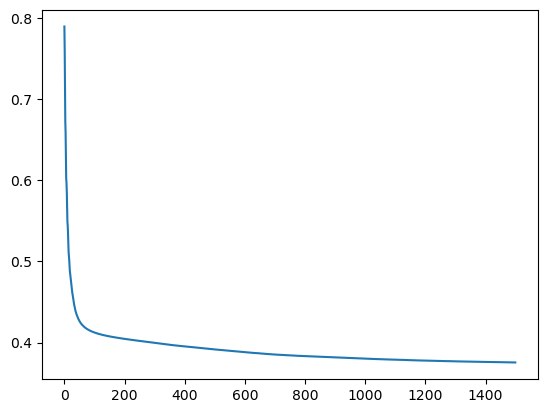

In [28]:
import torch
import torch.nn as nn

LEARNING_RATE = 0.001
EPOCHS = 1500

# Define the model
model = nn.Sequential(
    nn.Linear(x_train.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128, 2),
    nn.Softmax(dim=1)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

losses = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    
    y_pred = model(torch.tensor(x_train).float())
    loss = loss_fn(y_pred, torch.tensor(y_train).long())
    losses.append(loss.item())
    
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch} Loss {loss.item()}")
        
model.eval()
y_pred = model(torch.tensor(x_train).float())
y_pred = torch.argmax(y_pred, dim=1)

# Evaluate training accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy on training set is {accuracy}")

# Plot the loss
import matplotlib.pyplot as plt

plt.plot(losses)

In [29]:
# Evaluate the model

model.eval()
y_pred = model(torch.tensor(x_test).float())
y_pred = torch.argmax(y_pred, dim=1)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on testing set is {accuracy}")

report = classification_report(y_test, y_pred)
print(report)

# confusion_matrix(y_test, y_pred)
# display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=range(6))

# display.plot()


Accuracy on testing set is 0.9120475113122172
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1782
           1       0.91      0.91      0.91      1754

    accuracy                           0.91      3536
   macro avg       0.91      0.91      0.91      3536
weighted avg       0.91      0.91      0.91      3536



In [30]:
# Save the weights

weights_str = ""
biases_str = ""

for param in model.named_parameters():
    isBias = False
    if "0.weight" in param[0]:
        weights_str += ("custom_float input_weight[INPUT_NODES * HIDDEN_LAYER_NODES] = {")
        isBias = False
    if "0.bias" in param[0]:
        biases_str += ("custom_float input_bias[HIDDEN_LAYER_NODES] = {")
        isBias = True
    if "2.weight" in param[0]:
        weights_str += ("custom_float output_weight[HIDDEN_LAYER_NODES * OUTPUT_NODES] = {")
        isBias = False
    if "2.bias" in param[0]:
        biases_str += ("custom_float output_bias[OUTPUT_NODES] = {")
        isBias = True
        
    weight = param[1].detach().numpy().flatten().tolist()
    for w in weight:
        if isBias:
            biases_str += str(w) + ","
        else:
            weights_str += str(w) + ","
            
    if isBias:
        biases_str += "};\n\n"
    else:
        weights_str += "};\n\n"
        
print(weights_str)
print(biases_str)

custom_float input_weight[INPUT_NODES * HIDDEN_LAYER_NODES] = {0.15072178840637207,0.1955481469631195,0.19046291708946228,-0.09035028517246246,0.09171611070632935,-0.0955410748720169,-0.033693891018629074,0.05288703739643097,0.07532688230276108,-0.07164367288351059,-0.02538796328008175,-0.061559632420539856,-0.054385628551244736,-0.16833272576332092,-0.05226447805762291,-0.12205853313207626,0.012589620426297188,-0.16893929243087769,-0.13650628924369812,-0.1005462259054184,0.06253943592309952,-0.07128770649433136,0.09976907819509506,0.06546943634748459,0.0625317394733429,-0.12861698865890503,-0.052691053599119186,-0.13700030744075775,-0.09226344525814056,0.22125715017318726,-0.021425990387797356,0.05375172942876816,0.07666825503110886,0.18414431810379028,0.17542926967144012,0.008314218372106552,-0.011548807844519615,-0.03091220185160637,-0.020952889695763588,-0.05275503918528557,0.026036841794848442,0.18564113974571228,0.17522133886814117,-0.025586819276213646,-0.04034726321697235,0.126

In [36]:
# Generate test case

import random

TEST_CASES = 100

test_cases = []

for i in range(TEST_CASES):
    test_case = random.choice(x_test)
    test_cases.append(test_case)

test_cases = np.array(test_cases)

pred_output = np.argmax(model(torch.tensor(test_cases).float()).detach().numpy(), axis=1)

test_cases_str = "float test_case[TEST_CASES_NUMBER * INPUT_NODES] = {"
pred_output_str = "int test_output[TEST_CASES_NUMBER] = {"

for test_case in test_cases.flatten():
    test_cases_str += str(test_case) + ","
for output in pred_output:
    pred_output_str += str(output) + ","

test_cases_str += "};\n"
pred_output_str += "};\n"

# print the test cases and the predicted output
print(test_cases_str)
print(pred_output_str)

float test_case[TEST_CASES_NUMBER * INPUT_NODES] = {-0.6821,0.728,0.11196666666666664,0.5367156996233874,0.5482702587836282,0.07939999999999992,2.0975234134569267,5.639614779999997,-4.3705,1.1224,-0.7712333333333333,1.7795194938209833,1.939456233930875,2.9653999999999994,6.231609118839209,82.81004265999997,-0.7062,0.4927,-0.08715000000000002,0.45350376238792106,0.4618016727990491,0.41050000000000014,1.7329876543126321,4.059661459999999,-0.8494,3.6609,0.9588666666666666,1.4805764932019627,1.7639535245200386,2.810753640929777,5.7532,78.6640453,-1.0066,1.5737,0.46151666666666663,0.9408091081912183,1.0479119293464823,0.2209000000000001,3.7665611199076543,23.62450522,-3.5761,0.8573,-0.6904166666666667,1.4115226570582877,1.5713279049899165,2.8787,4.675474226214919,57.166894899999996,-1.3486,0.3987,-0.36623333333333336,0.6130343564778585,0.7140994165147222,1.1392657679400358,2.1974,12.588345279999997,-0.9858,4.1654,1.1023166666666666,1.7128096882186168,2.0368650082091024,3.217352963229244,6.6